In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from  gpdc import *
import statsmodels.api as sm

## Sampling a trajectory from the convolution model

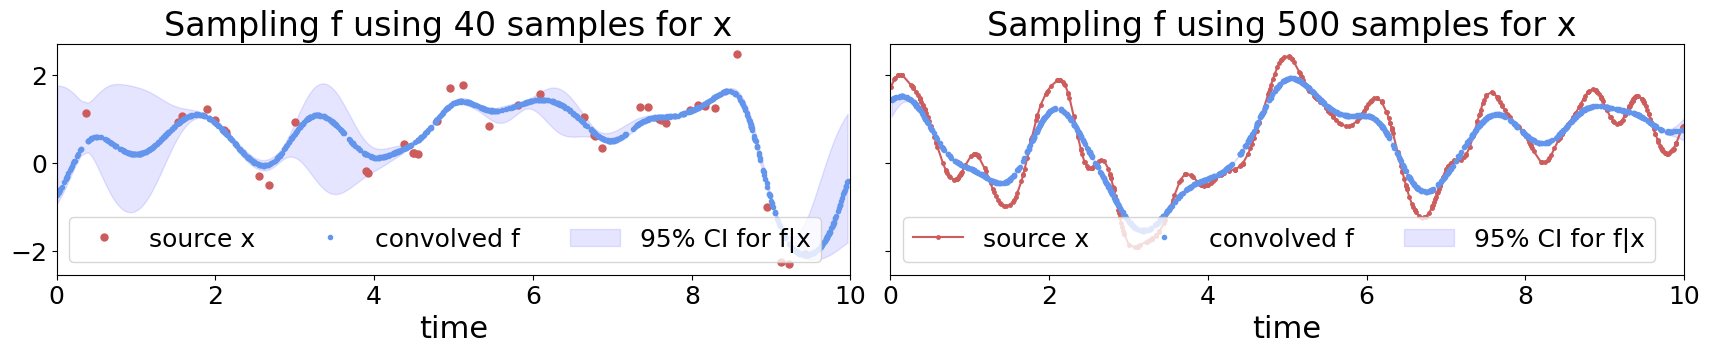

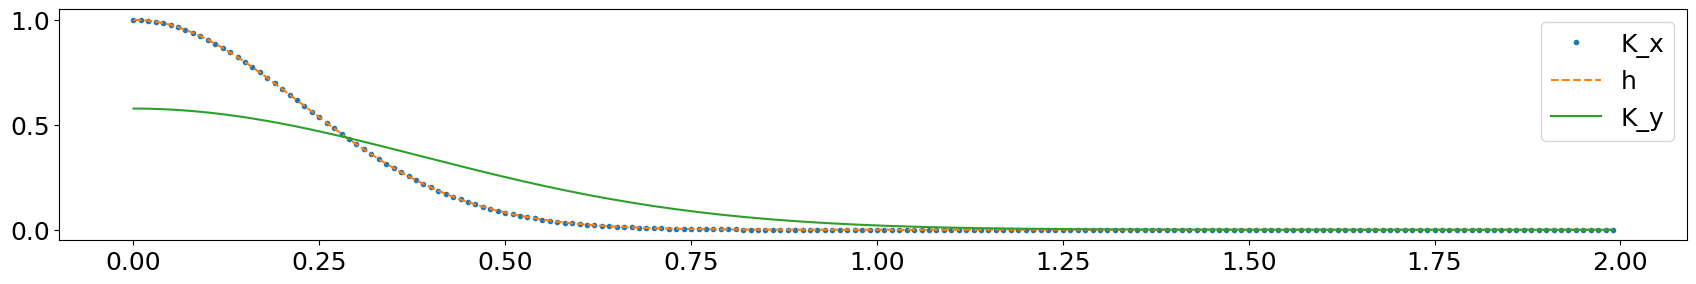

In [2]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,  figsize=(21,3))
f.subplots_adjust(wspace=0.05)

n = 40
times_x = np.random.rand(n)*10
times_x = np.sort(times_x)
times_f = np.random.rand(1000)*10
times_f = np.sort(times_f)

ex = 'RBF'

if ex == 'RBF':
    my_gpc = gpc('RBF-RBF')
    x, f, mf, vf, _ = my_gpc.sample_from_prior(times_x,times_f,[10,0,1,10,0]);
elif ex == 'Sinc':
    my_gpc = gpc('Sinc-Sinc')
    x, f, mf, vf, _= my_gpc.sample_from_prior(times_x,times_f,[0,3,1,0,10]);

ax1.plot(times_x, x,'.',c = 'indianred',ms = 10,label='source x')
ax1.plot(times_f, f,'.', c='cornflowerblue',label='convolved f')
#plt.plot(times_f, mf,'b-',label='mf')
ax1.fill_between(times_f, (mf-2*np.sqrt(np.diag(vf))), (mf+2*np.sqrt(np.diag(vf))),color='b', alpha=0.1,label='95% CI for f|x')
ax1.set_title(f'Sampling f using {n} samples for x ')
ax1.set_xlabel('time')
ax1.set_xlim([0,10])
ax1.legend(ncol=3)

n = 500
times_x = np.random.rand(n)*10
times_x = np.sort(times_x)
times_f = np.random.rand(1000)*10
times_f = np.sort(times_f)

if ex == 'RBF':
    x, f, mf, vf, paramy = my_gpc.sample_from_prior(times_x,times_f,[10,0,1,10,0]);
elif ex == 'Sinc':
    x, f, mf, vf, paramy = my_gpc.sample_from_prior(times_x,times_f,[0,3,1,0,60]);
    
ax2.plot(times_x, x,'.-',c = 'indianred', ms = 5, label='source x')
ax2.plot(times_f, f,'.', c='cornflowerblue',label='convolved f')
#plt.plot(times_f, mf,'b-',label='mf')
ax2.fill_between(times_f, (mf-2*np.sqrt(np.diag(vf))), (mf+2*np.sqrt(np.diag(vf))),color='b', alpha=0.1,label='95% CI for f|x')
ax2.set_title(f'Sampling f using {n} samples for x ')
ax2.set_xlim([0,10])
ax2.set_xlabel('time')
ax2.legend(ncol=3)

#plt.savefig('../paper/img/sampling.pdf', bbox_inches = 'tight')

f, (ax1) = plt.subplots(1, 1, sharey=True,  figsize=(21,3))
if ex == 'RBF':
    new_times = np.arange(0, 2,0.01)
    ax1.plot(new_times, Spec_Mix(0,new_times,10,0,1).flatten(),'.',label="K_x")
    ax1.plot(new_times, Spec_Mix(0,new_times,10,0,1).flatten(),'--',label="h")
    ax1.plot(new_times, Spec_Mix(0,new_times,paramy[0],paramy[1],paramy[2]).flatten(),label="K_y")
elif ex == 'Sinc':     
    new_times = np.arange(0, 2,0.01)
    ax1.plot(new_times, Sinc(0,new_times,0,3,1).flatten(),label="K_x")
    ax1.plot(new_times, Sinc(0,new_times,0,60,1).flatten(),label="h")
    ax1.plot(new_times, Sinc(0,new_times,paramy[0],paramy[1],paramy[2]).flatten(),label="K_y")
ax1.legend()

## Deconvolution: Sinc case

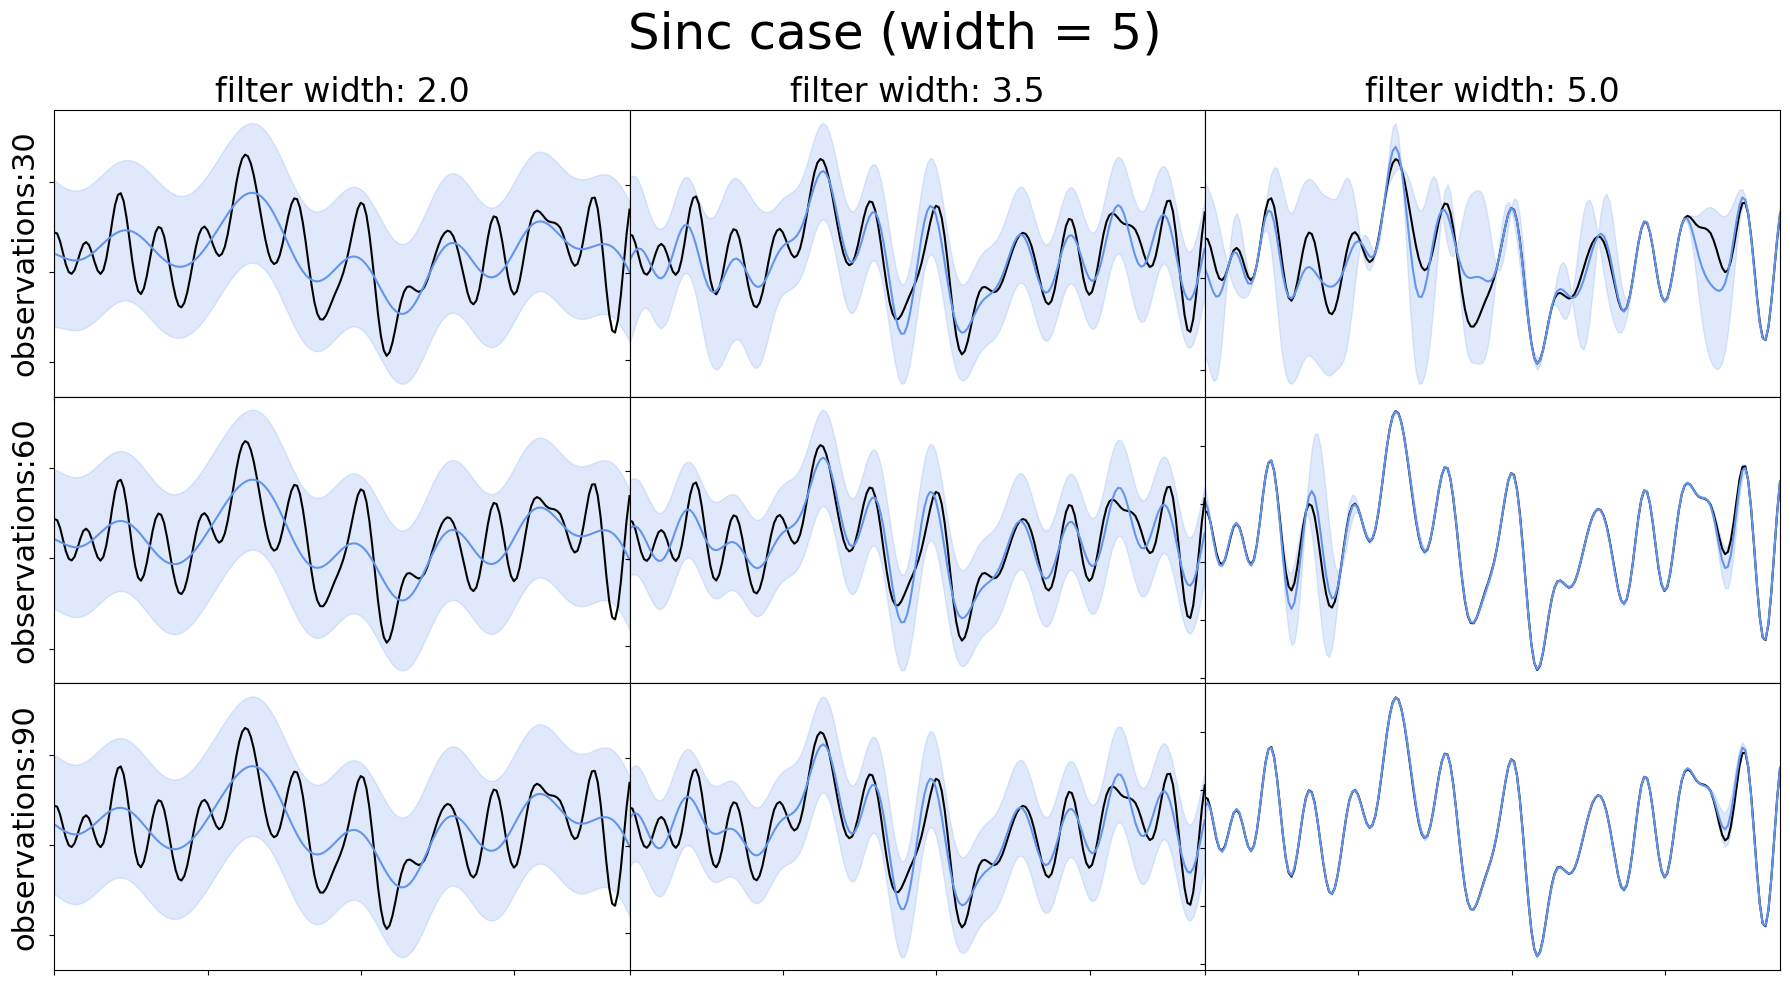

In [ ]:
np.random.seed(1)
times_x = np.linspace(0, 7.5,200)
times_f = np.linspace(0, 7.5,200)
delta = 5

def generate_post(npoints, delta_h):
    sigma_n = 0.01
    params = [0,delta,1,0,delta_h,1,sigma_n] #xi_x, delta_x, sigma_x, xi_h, delta_h, sigma_h, sigma_n
    my_gpc = gpc('Sinc-Sinc',params)
    x, f, mf, vf, paramy = my_gpc.sample_from_prior(times_x,times_f,params);
    y = f + 0.1*np.random.randn(len(times_f))
    indices = np.random.randint(0, len(times_f), size=npoints) 
    indices =np.sort(indices)
    signal_obs = f[indices] + sigma_n*np.random.randn(npoints)
    times_y = times_f[indices]
    my_gpc.set_observations(times_y, signal_obs)
    time_label = 'time'
    signal_label = ''
    my_gpc.set_labels(time_label,signal_label)
    my_gpc.compute_moments(times_x = times_x, times_y = times_y)
    my_gpc.plot_posterior_x(times_x,x)
    
    
V_npoints = [30,60,90]
V_deltas = [2,3.5,5]
f, ax = plt.subplots(len(V_npoints), len(V_deltas), figsize=(18,10))

    

for i in range(len(V_npoints)):
    ax[i,0].set_ylabel(f'observations:{V_npoints[i]}')
    for j in range(len(V_deltas)):
        ax[0,j].set_title(f'filter width: {V_deltas[j]:.1f}')
        plt.sca(ax[i,j]) 
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        generate_post(V_npoints[i],V_deltas[j])
        #plt.title(f'{V_npoints[i]} obs.,  {(V_deltas[j]/delta*100):.0f}% overlap')

f.suptitle(f'Sinc case (width = {delta})', fontsize=36)
f.subplots_adjust(wspace=0, hspace=0,top=0.88)
#plt.savefig('img-PRSA/deconv_synth_Sinc.pdf', bbox_inches = 'tight')

## Deconvolution: Gaussian case

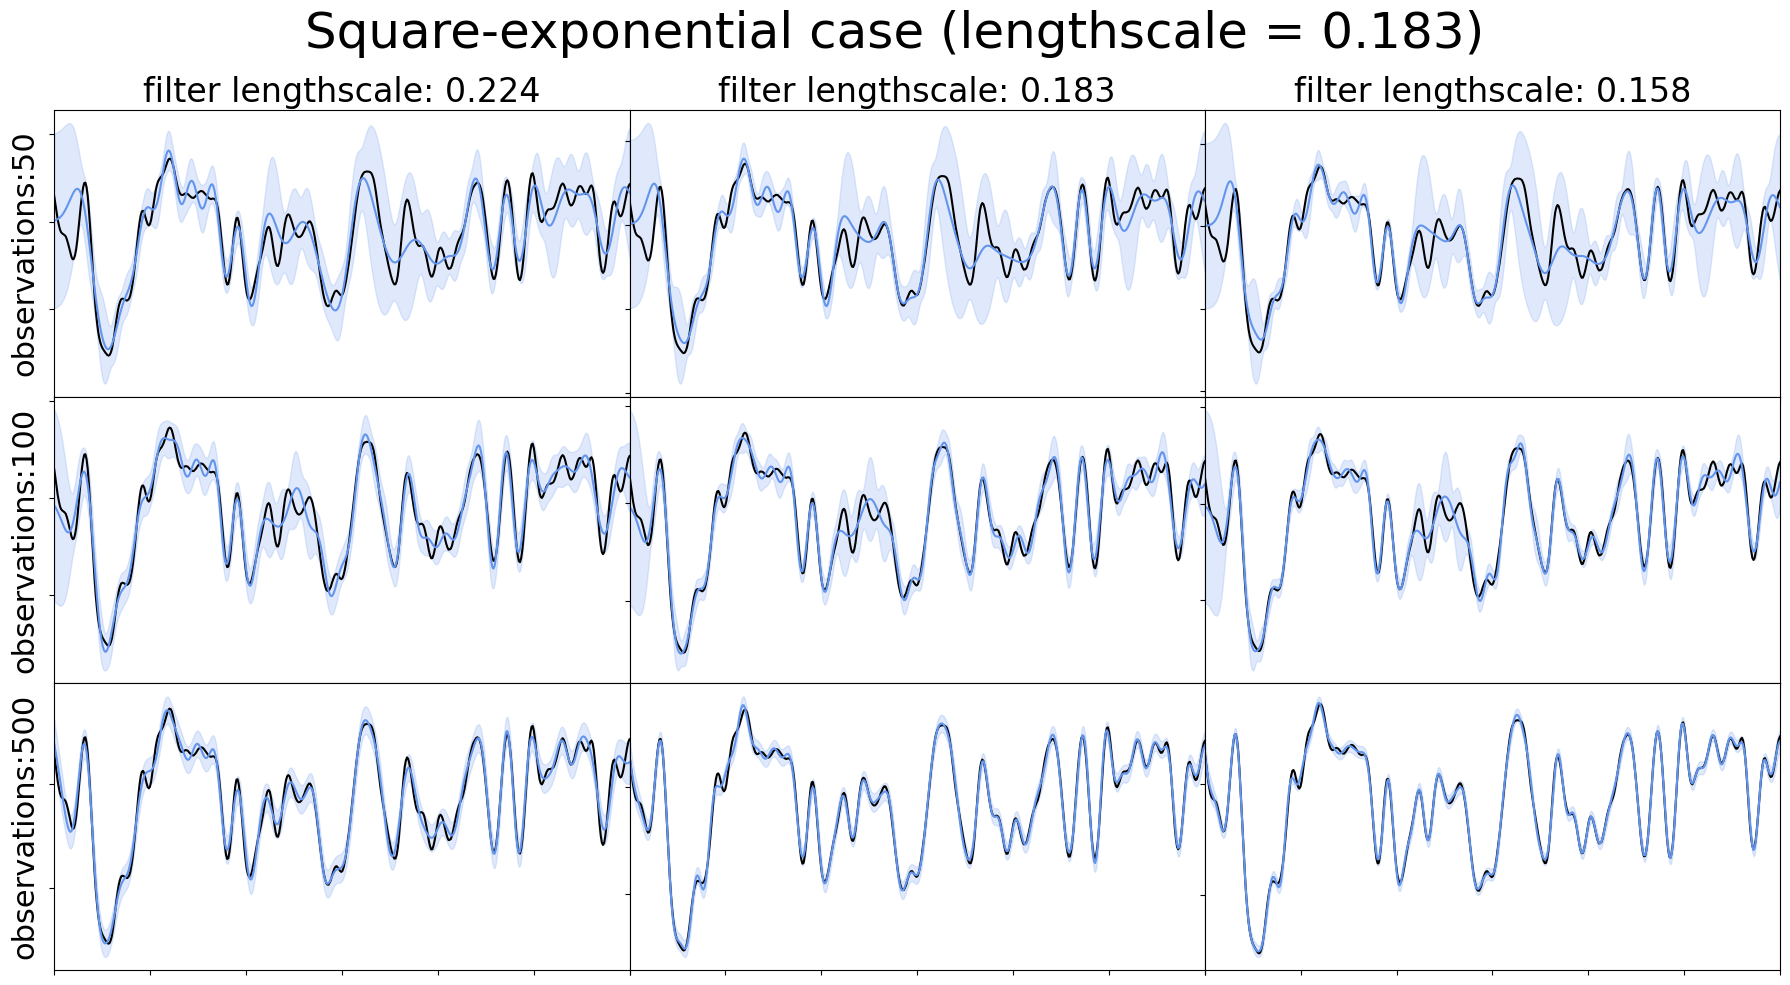

In [ ]:
np.random.seed(1)
times_x = np.linspace(0, 15,500)
times_f = np.linspace(0, 15,500)
gamma_x = 15

def generate_post_SM(npoints, gamma_h):
    sigma_n = 0.01
    sigma_h = (gamma_h/np.pi)**(0.25)
    params = [gamma_x,0,1,gamma_h,0, sigma_h, sigma_n] #gamma_x, theta_x, sigma_x, gamma_h, theta_h
    my_gpc = gpc('RBF-RBF',params)
    x, f, mf, vf, paramy = my_gpc.sample_from_prior(times_x,times_f,params);
    y = f + 0.1*np.random.randn(len(times_f))
    indices = np.random.randint(0, len(times_f), size=npoints) 
    indices =np.sort(indices)
    signal_obs = f[indices] + sigma_n*np.random.randn(npoints)
    times_y = times_f[indices]
    my_gpc.set_observations(times_y, signal_obs)
    time_label = 'time'
    signal_label = ''
    my_gpc.set_labels(time_label,signal_label)
    my_gpc.compute_moments(times_x = times_x, times_y = times_y)
    my_gpc.plot_posterior_x(times_x,x)
    
    
V_npoints = [50, 100, 500]
V_gammas = [10,15,20]
f, ax = plt.subplots(len(V_npoints), len(V_gammas), figsize=(18,10))
plt.subplots_adjust(wspace=0, hspace=0)

    

for i in range(len(V_npoints)):
    ax[i,0].set_ylabel(f'observations:{V_npoints[i]}')
    for j in range(len(V_gammas)):
        ax[0,j].set_title(f'filter lengthscale: { np.sqrt((1/V_gammas[j])/2):.3f}')
        plt.sca(ax[i,j]) 
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        generate_post_SM(V_npoints[i],V_gammas[j])
        #plt.title(f'{V_npoints[i]} obs.,  {(V_deltas[j]/delta*100):.0f}% overlap')

f.suptitle(f'Square-exponential case (lengthscale = {np.sqrt((1/gamma_x)/2):.3f})', fontsize=36)

f.subplots_adjust(wspace=0, hspace=0,top=0.88)

#plt.savefig('img-PRSA/deconv_synth_SE.pdf', bbox_inches = 'tight')

## Example: de-reverberation

In [5]:
from scipy.io import wavfile
import statsmodels as sm
import scipy.signal as ss
print('acquiring')
fs_o, speech = wavfile.read('./data/dryspeech.wav')
print(f'[true] size: {speech.shape} fs  {fs_o}')

acquiring
[true] size: (63039,) fs  22050


[reve] size: (38245,) fs  11025
resampling
[true] size: (2000,) fs  5512.5
[reve] size: (2000,) fs  5512.5


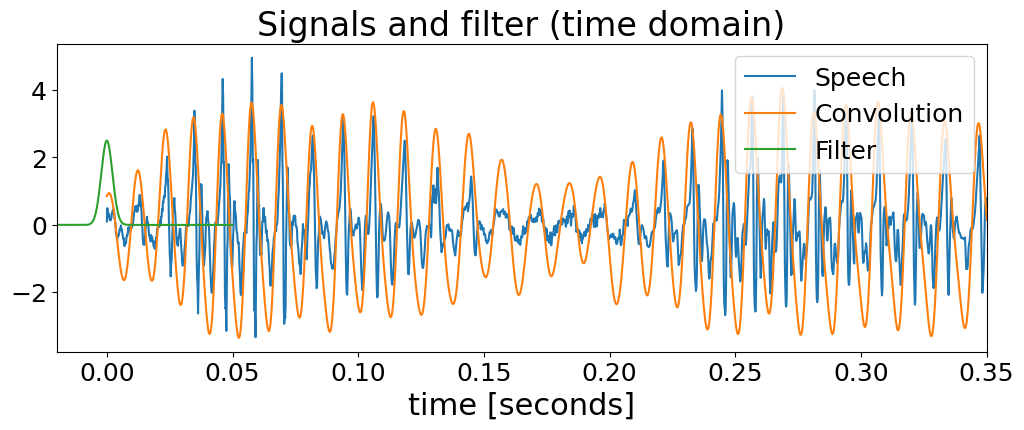

In [6]:
fs_r, speech_r = wavfile.read('./data/lecture600ms.wav')
speech_r = (speech_r[:,1] + speech_r[:,0])/2
print(f'[reve] size: {speech_r.shape} fs  {fs_r}')

#resampling: 
speech = ss.resample(speech,int(speech.shape[0]/2))
fs_o = fs_o/2
speech = speech[10500:14500]
speech_r = speech_r[10500:14500]
speech -= np.mean(speech)
speech /= np.std(speech)
speech_r -= np.mean(speech_r)
speech_r /= np.std(speech_r)

print('resampling')
div = 2
speech = ss.resample(speech,int(speech.shape[0]/div))
speech_r = ss.resample(speech_r,int(speech_r.shape[0]/div))
fs_o = fs_o/div
fs_r = fs_r/div
print(f'[true] size: {speech.shape} fs  {fs_o}')
print(f'[reve] size: {speech_r.shape} fs  {fs_r}')

times_h = np.arange(-0.05,0.05,1/fs_o)
times_speech = np.arange(len(speech))/fs_o

delta_t = times_speech[1] - times_speech[0]
gamma_h = 100000
sigma_h = 1
h = sigma_h**2*np.exp(-100000*(times_h)**2)

sigma_noise = 1e-10
speech_r = delta_t*np.convolve(speech,h,mode='same') + sigma_noise*np.random.randn(len(speech))


plt.figure(figsize=(12,4))

plt.plot(times_speech, speech,label = 'Speech')
plt.title('Signals and filter (time domain)')
plt.plot(times_speech,1400*speech_r,label = 'Convolution')
plt.plot(times_h,h*2.5,label='Filter')
plt.xlim([-0.02,0.35])
plt.xlabel('time [seconds]')
plt.legend(loc='upper right')
#plt.savefig('../paper/img/audio_time.pdf', bbox_inches = 'tight')


In [7]:
#training for the unconvolved signal x to obtin hyperparameters
my_gpc = gpc('RBF-RBF')
my_gpc.set_observations(times_speech,speech)
my_gpc.train()



Hyperparameters are:
sigma =0.9461626869192243
gamma =1895136.0544127391
theta =1.0
sigma_n =0.11624034233422047


In [8]:
#for y
#my_gpc2 = gpc('RBF-RBF')
#my_gpc2.set_observations(times_speech,speech_r)
#my_gpc2.train()



In [9]:
#gamma_h, sigma_h is known (non-blind case)
gamma_x = my_gpc.gamma #1895136.0544127391
sigma_x = my_gpc.sigma_x #0.93
params = [gamma_x, 0, sigma_x, gamma_h, 0, sigma_h, 1e-10]
my_gpc3 = gpc('RBF-RBF',params)
my_gpc3.set_observations_no_hype(times_speech, speech_r)
my_gpc3.compute_moments(times_x=times_speech,times_y=times_speech)
    
    


/Users/felipe/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


Text(0.5, 0, 'frequency [1/secs]')

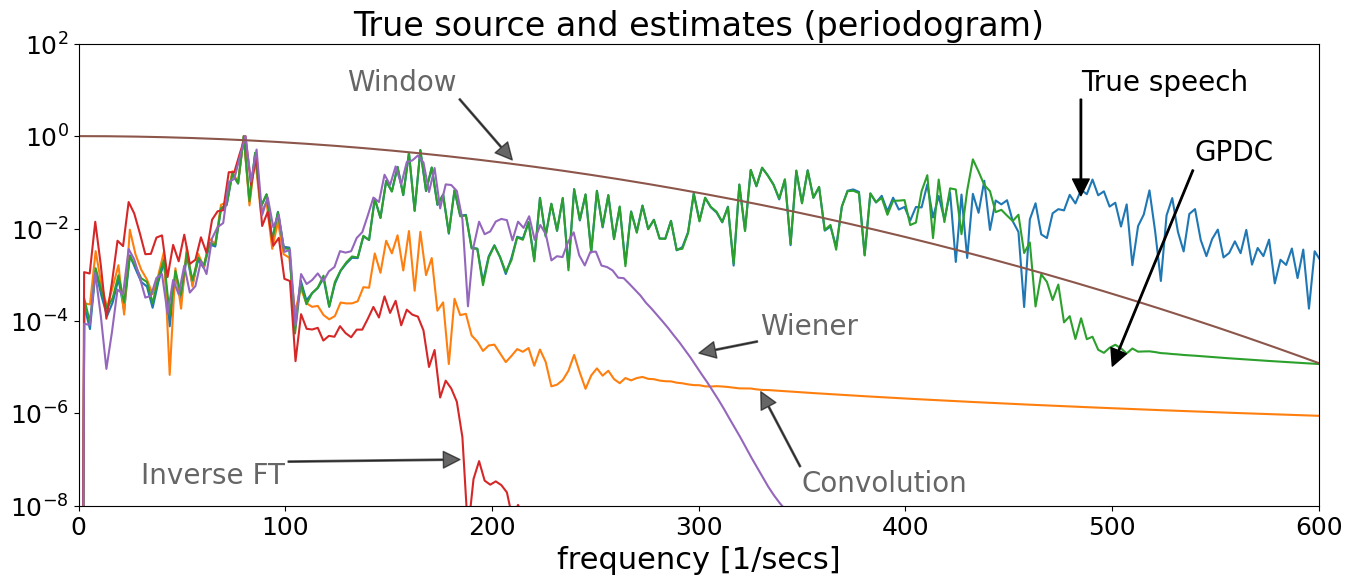

In [10]:
#inverse FT
import scipy
import scipy.fft as fft
speech_r = speech_r

#convolution
conv_f = scipy.fft.fft(speech_r,2048)

#inverseFT
h_f = scipy.fft.fft(h,2048)
speech_FT = scipy.fft.ifft(conv_f*h_f)

#wiener
wiener = np.real(fft.ifft(fft.fft(speech_r,2048)*np.conj(h_f)/(np.abs(h_f*np.conj(h_f)) + 1e-1)))

#periodograms
f_true, Pxx_true = ss.periodogram(speech, fs_o);
f_rev, Pxx_rev = ss.periodogram(speech_r, fs_o);
speech_est = my_gpc3.post_mean_x
speech_est -= np.mean(speech_est)
speech_est /= np.std(speech_est)
speech_est_std = np.sqrt(np.diag(my_gpc3.post_cov_x))
f_est, Pxx_est = ss.periodogram(speech_est, fs_o);
f_est, Pxx_est_up = ss.periodogram(speech_est+2*speech_est_std, fs_o);
f_est, Pxx_est_lo = ss.periodogram(speech_est-2*speech_est_std, fs_o);


f_FT, Pxx_FT = ss.periodogram(speech_FT, fs_o);
f_W, Pxx_w = ss.periodogram(wiener, fs_o);


#plt.figure(figsize=(12,4))
plt.figure(figsize=(16,6))

plt.semilogy(f_true, Pxx_true/np.max(Pxx_true[10:100]),label='Source (x)');
plt.semilogy(f_rev, Pxx_rev/np.max(Pxx_rev[10:100]),label='Convolution (f)');
plt.semilogy(f_est, Pxx_est/np.max(Pxx_est[10:100]),label='GPDC');
plt.semilogy(f_FT, Pxx_FT/np.max(Pxx_FT[10:100]),label='Inverse FT');
plt.semilogy(f_W, Pxx_w/np.max(Pxx_w[10:100]),label='Wiener');
plt.semilogy(f_true, np.exp(-np.pi*f_true**2/gamma_h),label='window');


plt.annotate('Wiener', xy=(300,2*1e-5), xytext=(330,0.5*1e-4), size=20, alpha = 0.6,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1, alpha = 0.6),
            )

plt.annotate('Convolution', xy=(330,3e-6), xytext=(350,2*1e-8), size=20, alpha = 0.6,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1, alpha = 0.6),
            )


plt.annotate('Inverse FT', xy=(185,1e-7), xytext=(30,3e-8), size=20, alpha = 0.6,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1, alpha = 0.6),
            )

plt.annotate('Window', xy=(210,3e-1), xytext=(130,1e1), size=20, alpha = 0.6,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1, alpha = 0.6),
            )

plt.annotate('GPDC', xy=(500,1e-5), xytext=(540,3e-1), size=20,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1),
            )

plt.annotate('True speech', xy=(485,5e-2), xytext=(485,10), size=20,
            arrowprops=dict(facecolor='black', shrink=0.005, width=1),
            )

plt.title('True source and estimates (periodogram)')
#plt.legend(ncol = 2)
plt.xlim([0, 600])
plt.ylim([1e-8, 100])
plt.xlabel('frequency [1/secs]')

#plt.savefig('../paper/img/audio_freq_sm.pdf', bbox_inches = 'tight')

## figures for supplementary material

In [11]:
plot_params = {'legend.fontsize': 18,
          'figure.figsize': (15, 5),
         'xtick.labelsize':'18',
         'ytick.labelsize':'18',
         'axes.titlesize':'24',
         'axes.labelsize':'22'}
plt.rcParams.update(plot_params)

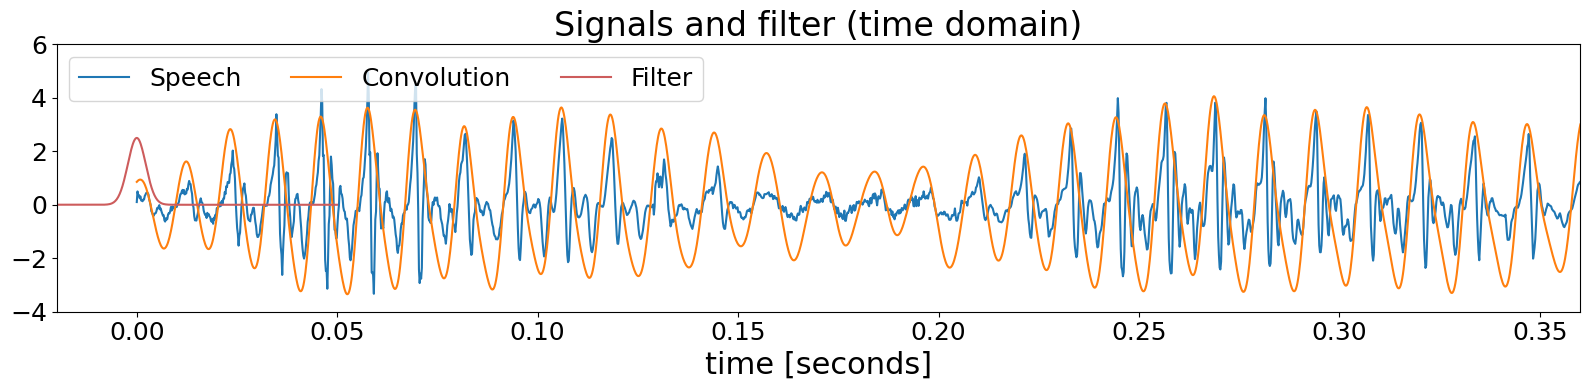

In [12]:

plt.figure(figsize=(16,4))

plt.plot(times_speech, speech,label = 'Speech')
plt.title('Signals and filter (time domain)')
plt.plot(times_speech,1400*speech_r,label = 'Convolution')
plt.plot(times_h,h*2.5,c='indianred',label='Filter')
plt.xlim([-0.02,0.36])
plt.ylim([-4,6])

plt.xlabel('time [seconds]')
plt.legend(loc='upper left', ncol = 3)
plt.tight_layout()
#plt.savefig('../paper/img/audio_time_sm.pdf', bbox_inches = 'tight')

(-4.0, 6.0)

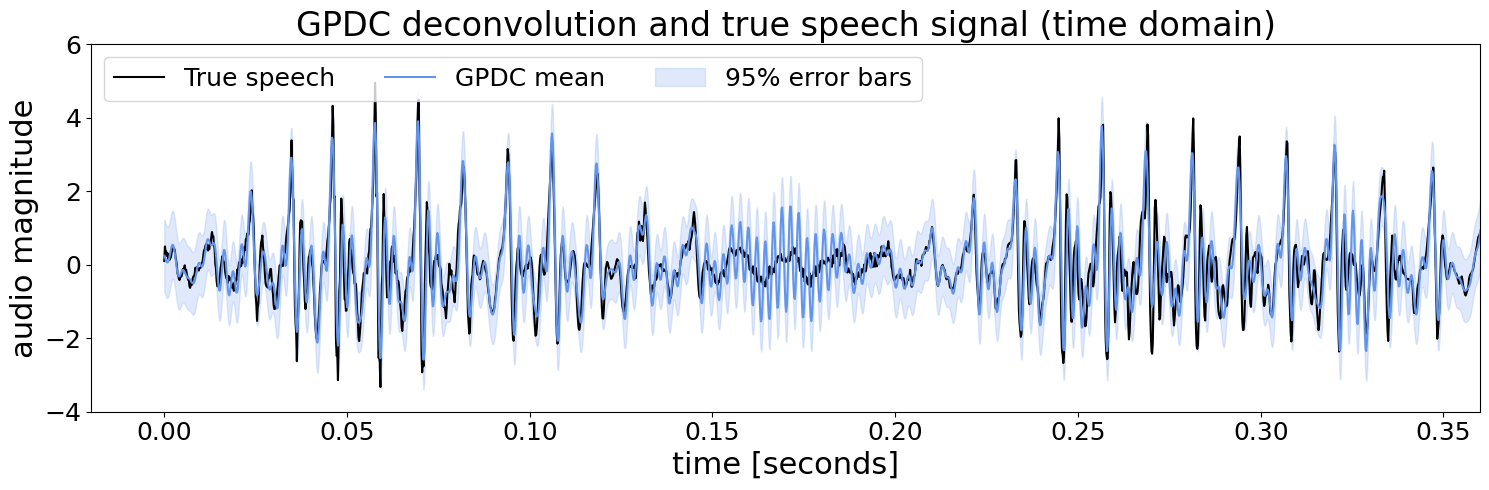

In [13]:
my_gpc3.time_label = 'time [seconds]'
my_gpc3.signal_label = 'audio magnitude'
my_gpc3.plot_posterior_x(time_truth=times_speech, ground_truth=speech, format=True)
plt.xlim([-0.02,0.36])
plt.ylim([-4,6])
#plt.savefig('../paper/img/audio_time_GPDC_sm.pdf', bbox_inches = 'tight')


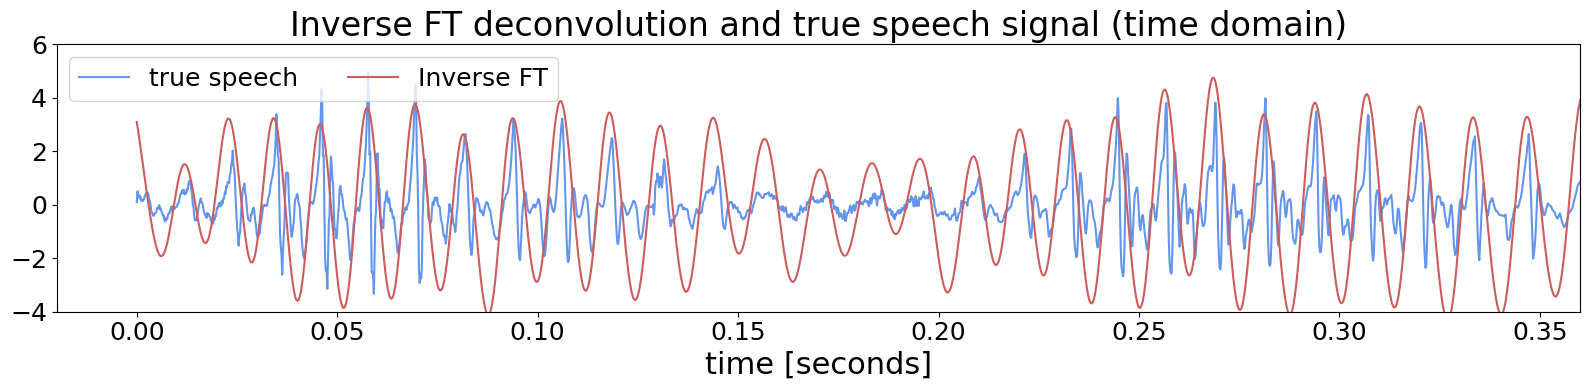

In [14]:
#convolution
conv_f = scipy.fft.fft(speech_r,2000)

#inverseFT
h_f = scipy.fft.fft(h,2000)
inv_FT = scipy.fft.ifft(conv_f*h_f)
til=278
invFT_fixed = np.hstack((inv_FT[til:],inv_FT[:til]))
invFT_fixed = np.real(invFT_fixed)

plt.figure(figsize=(16,4))

#plt.plot(times_speech, speech,label = 'Speech')
plt.title('Inverse FT deconvolution and true speech signal (time domain)')
plt.plot(times_speech,speech, c='cornflowerblue',label='true speech')
plt.plot(times_speech,invFT_fixed*100,c='indianred',label = 'Inverse FT')
plt.xlim([-0.02,0.36])
plt.ylim([-4,6])
plt.xlabel('time [seconds]')
plt.legend()
plt.legend(loc='upper left', ncol = 3)
plt.tight_layout()
#plt.savefig('../paper/img/audio_time_inv_FT_sm.pdf', bbox_inches = 'tight')

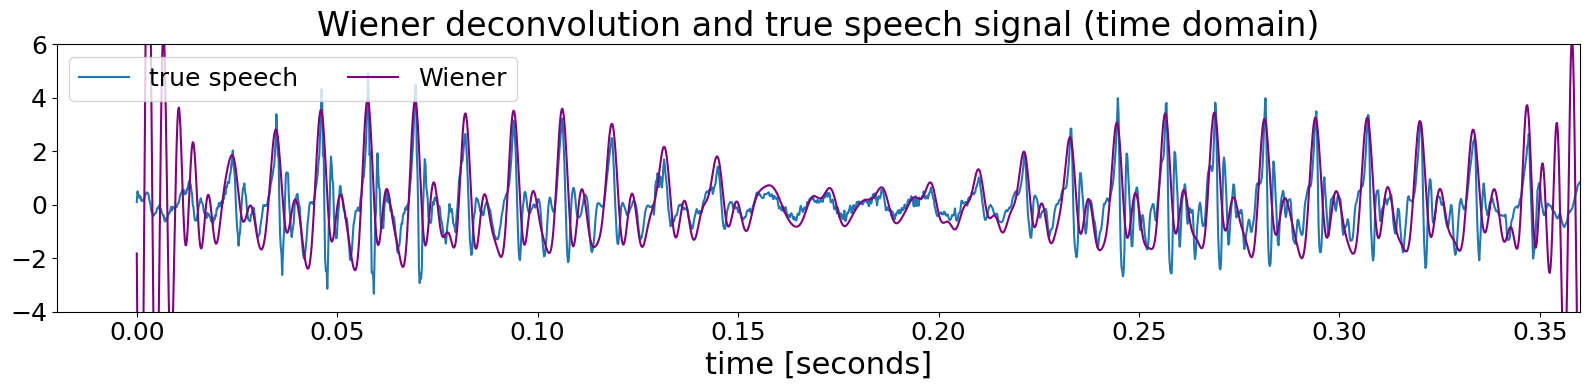

In [15]:
h_f = scipy.fft.fft(h,2000)
Kx = 1*np.exp(-gamma_x*(times_h)**2)
S_f = scipy.fft.fft(Kx,2000)

wiener = np.real(fft.ifft(fft.fft(speech_r,2000)*np.conj(h_f)/(np.abs(h_f)**2 + 1e-3),2000))
til = 278
win_fixed = np.hstack((wiener[-til:],wiener[:-til]))


plt.figure(figsize=(16,4))

#plt.plot(times_speech, speech,label = 'Speech')
plt.title('Wiener deconvolution and true speech signal (time domain)')
plt.plot(times_speech, speech,label='true speech')
plt.plot(times_speech,win_fixed*10000,c='purple',label='Wiener')

plt.xlim([-0.02,0.36])
plt.ylim([-4,6])
plt.xlabel('time [seconds]')
plt.legend(loc='upper left', ncol = 3)
plt.tight_layout()
#plt.savefig('../paper/img/audio_time_wiener_sm.pdf', bbox_inches = 'tight')


In [16]:
#-----this (was) the end

## quantitative comparison




Difference between true and convolved signal: 39.29287186151349
Difference between true and GPDC estimate: 21.663013881492258
Difference between true and inverse FT estimate: 41.88741065674526
Difference between true and Wiener estimate: 35.022217473628025


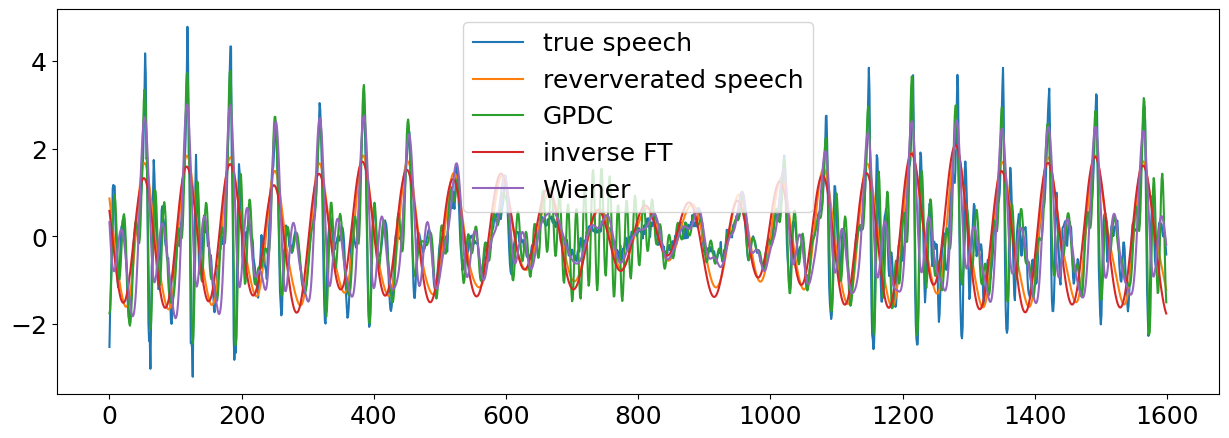

In [17]:
#1) Arnaud: this first cell focuses on the  comparison directly 
# on the time domain by comparing the signals: true, convelved, and the three estimates

#let's first standardise  and cut borders (to avoid border effect)
speech_s = (speech[200:-200] - np.mean(speech[200:-200]))/np.std(speech[200:-200])
speech_rs = (speech_r[200:-200] - np.mean(speech_r[200:-200]))/np.std(speech_r[200:-200])
gpdc_s = (speech_est[200:-200] - np.mean(speech_est[200:-200]))/np.std(speech_est[200:-200])
inv_FT_s = (invFT_fixed[200:-200] - np.mean(invFT_fixed[200:-200]))/np.std(invFT_fixed[200:-200])
wiener_s = (win_fixed[200:-200] - np.mean(win_fixed[200:-200]))/np.std(win_fixed[200:-200])

#now plot to make sure things make sense
plt.figure()
plt.plot(speech_s, label = 'true speech')
plt.plot(speech_rs, label = 'reververated speech')
plt.plot(gpdc_s, label = 'GPDC')
plt.plot(inv_FT_s, label = 'inverse FT')
plt.plot(wiener_s, label = 'Wiener')
plt.legend()

#now compute the differences to compose the table
print(f'Difference between true and convolved signal: {np.linalg.norm(speech_s-speech_rs)}')
print(f'Difference between true and GPDC estimate: {np.linalg.norm(speech_s-gpdc_s)}')
print(f'Difference between true and inverse FT estimate: {np.linalg.norm(speech_s-inv_FT_s)}')
print(f'Difference between true and Wiener estimate: {np.linalg.norm(speech_s-wiener_s)}')


0.01877224804806196


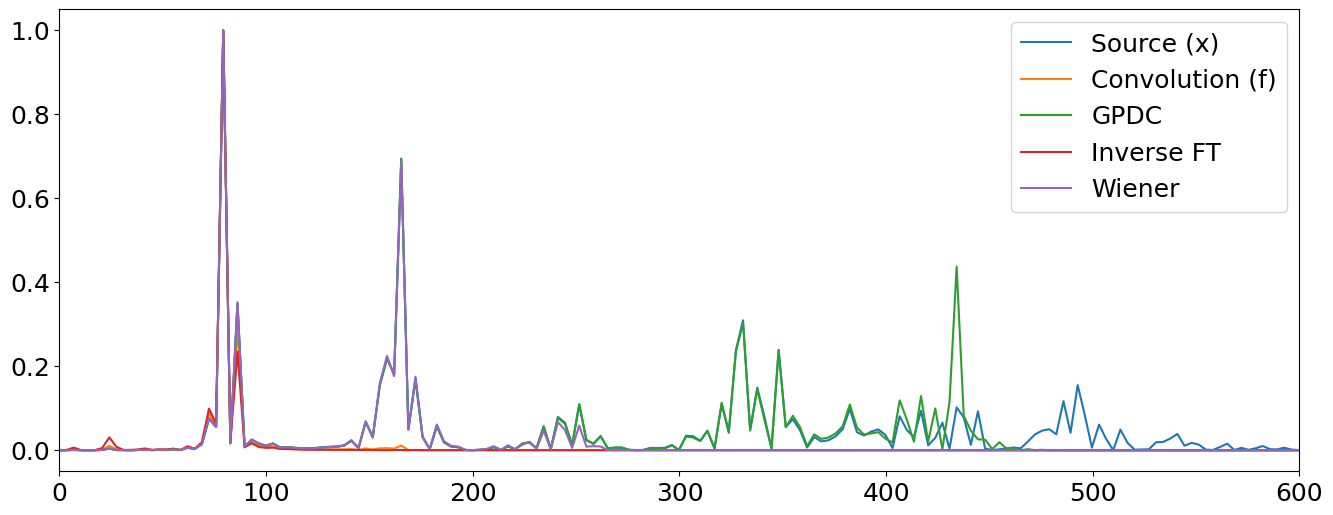

In [19]:
#2) this cell compares estimates in the spectral domain 
#  by comparing PSDs

#first compute the PSDs
f_true, Pxx = ss.periodogram(speech_s, fs_o);
f_true, Pxx_r = ss.periodogram(speech_rs, fs_o);
f_true, Pxx_gpdc = ss.periodogram(gpdc_s, fs_o);
f_true, Pxx_ft = ss.periodogram(inv_FT_s, fs_o);
f_true, Pxx_w = ss.periodogram(wiener_s, fs_o);


#let's plot
plt.figure(figsize=(16,6))
plt.plot(f_true, Pxx/np.max(Pxx[10:100]),label='Source (x)');
plt.plot(f_true, Pxx_r/np.max(Pxx_r[10:100]),label='Convolution (f)');
plt.plot(f_true, Pxx_gpdc/np.max(Pxx_gpdc[10:100]),label='GPDC');
plt.plot(f_true, Pxx_ft/np.max(Pxx_ft[10:100]),label='Inverse FT');
plt.plot(f_true, Pxx_w/np.max(Pxx_w[10:100]),label='Wiener');
plt.xlim([0, 600])
plt.legend()

# compute the differences between Pxx and the de-reverbered PSD. 

# using euclidean distance
print(np.sqrt(np.sum((Pxx-Pxx_gpdc)**2)))



